# 1. Load Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF

import tensorflow as tf

**Note:** Using `CK+`. Mapping from labels to emotions is as follows: 

```0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise```

In [3]:
DATASET_DIR = "/Users/samuilstoychev/ckplus_cropped/"
EMOTION_MAPPING = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

In [33]:
img_size = 48
batch_size = 32

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(DATASET_DIR + "train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(DATASET_DIR + "test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 1050 images belonging to 8 classes.
Found 258 images belonging to 8 classes.


# 2. Examine the Dataset
**Note:** Once the data is labelled (for demographic attributes such as gender), we can also do data exploration in terms of the dataset balance, etc. 

In [5]:
data = train_generator.next()

Ground truth 0 = neutral


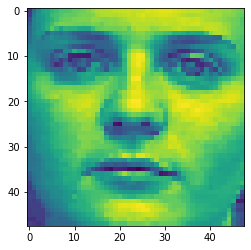

In [6]:
plt.imshow(data[0][0])
label = np.argmax(data[1][0])
print("Ground truth", label, "=", EMOTION_MAPPING[label])

# 3. Defining the Model Architecture
Architecture originally proposed by [Goodfellow et al., 2013](https://arxiv.org/pdf/1307.0414.pdf). 

In [98]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(8, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 128)      

# 4. Training the Baseline Model 
Baseline here stands for the original, *un-compressed* version. Later we will apply compression strategies on top of it.

**TODO:** Run evaluation multiple times with multipe hyperparameters - learning rate, batch size, number of iterations (perhaps performing a grid search?). Report the values for the different parameters to justify your choice of hyperparameters. 

**TODO:** Consider some sort of cross-validation (possibly *cross-subject validation* as well?). 

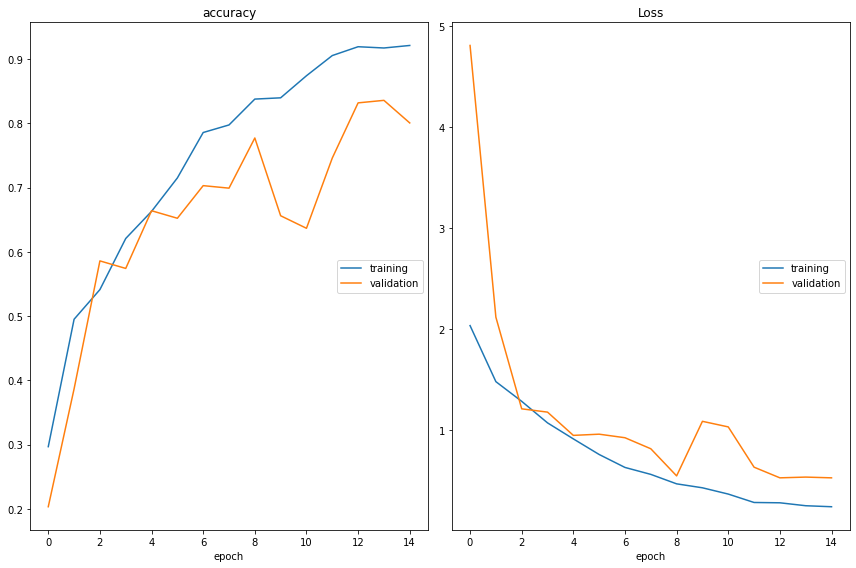

accuracy
	training         	 (min:    0.297, max:    0.921, cur:    0.921)
	validation       	 (min:    0.203, max:    0.836, cur:    0.801)
Loss
	training         	 (min:    0.244, max:    2.037, cur:    0.244)
	validation       	 (min:    0.530, max:    4.810, cur:    0.530)

Epoch 00015: saving model to model_weights.h5
32/32 [==============================] - 34s 1s/step - loss: 0.2449 - accuracy: 0.9214 - val_loss: 0.5300 - val_accuracy: 0.8008
CPU times: user 16min 39s, sys: 4min 21s, total: 21min
Wall time: 8min 10s


In [99]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Saving the trained model

In [100]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# 5. Manually Testing the Trained Model 

### Loading the trained model from the JSON file. 

In [41]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")

### Generating a batch of validation data. 

In [34]:
validation_data = validation_generator.next()

### Generating predictions on the validation data (using the trained classifier). 

In [36]:
predictions = loaded_model.predict(validation_data[0])

Image data:


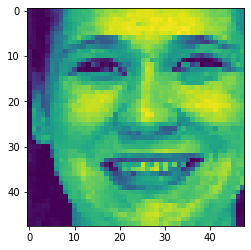

Original label: happy
Predicted label: happy
Image data:


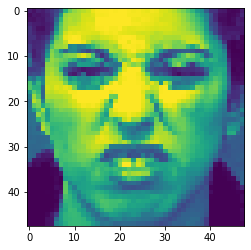

Original label: disgust
Predicted label: disgust
Image data:


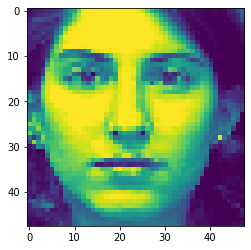

Original label: neutral
Predicted label: neutral
Image data:


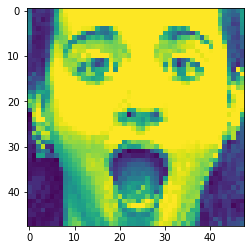

Original label: surprise
Predicted label: surprise
Image data:


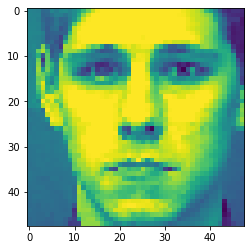

Original label: sadness
Predicted label: sadness
Image data:


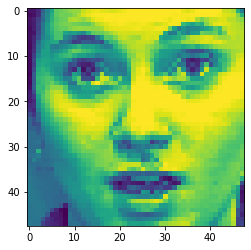

Original label: surprise
Predicted label: surprise
Image data:


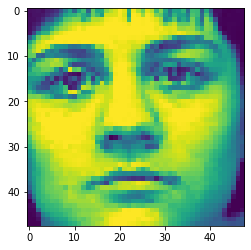

Original label: neutral
Predicted label: neutral
Image data:


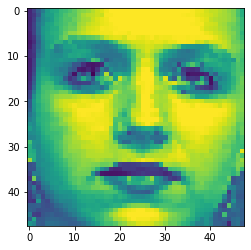

Original label: neutral
Predicted label: neutral
Image data:


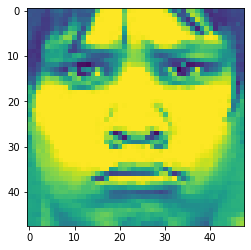

Original label: sadness
Predicted label: sadness
Image data:


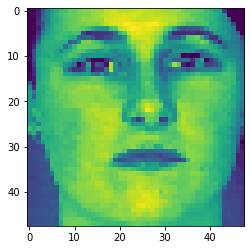

Original label: neutral
Predicted label: contempt
Image data:


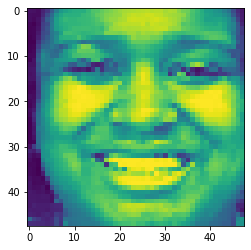

Original label: happy
Predicted label: happy
Image data:


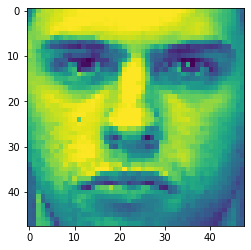

Original label: neutral
Predicted label: neutral
Image data:


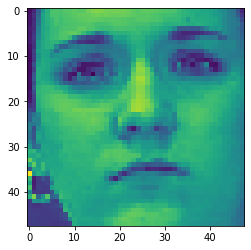

Original label: neutral
Predicted label: neutral
Image data:


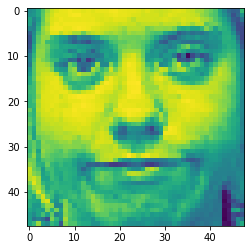

Original label: contempt
Predicted label: contempt
Image data:


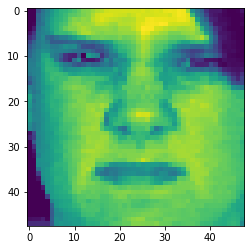

Original label: disgust
Predicted label: disgust
Image data:


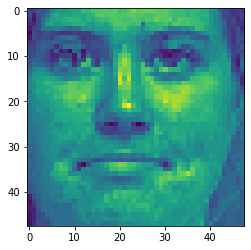

Original label: contempt
Predicted label: contempt
Image data:


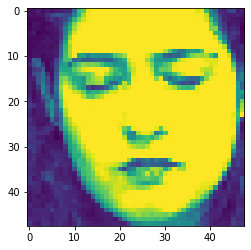

Original label: neutral
Predicted label: contempt
Image data:


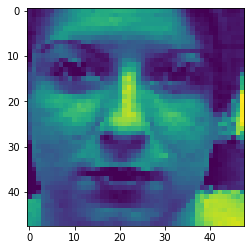

Original label: neutral
Predicted label: neutral
Image data:


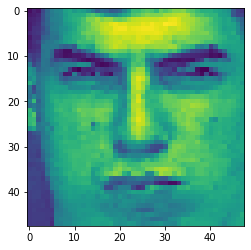

Original label: anger
Predicted label: anger
Image data:


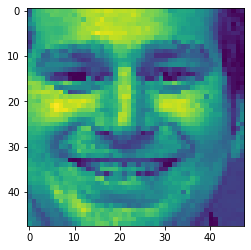

Original label: happy
Predicted label: happy
Image data:


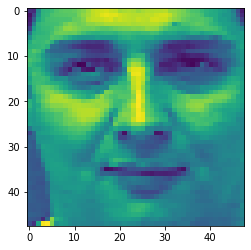

Original label: neutral
Predicted label: contempt
Image data:


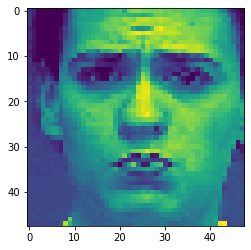

Original label: sadness
Predicted label: sadness
Image data:


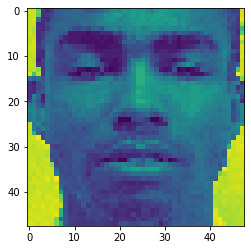

Original label: neutral
Predicted label: contempt
Image data:


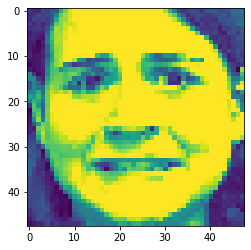

Original label: fear
Predicted label: fear
Image data:


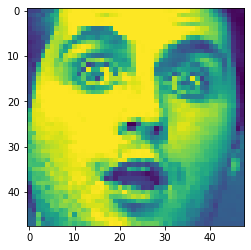

Original label: surprise
Predicted label: surprise
Image data:


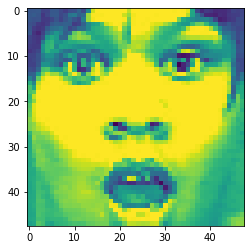

Original label: surprise
Predicted label: surprise
Image data:


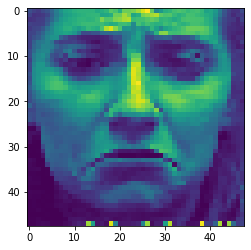

Original label: sadness
Predicted label: sadness
Image data:


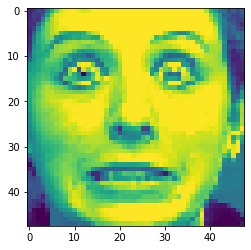

Original label: fear
Predicted label: fear
Image data:


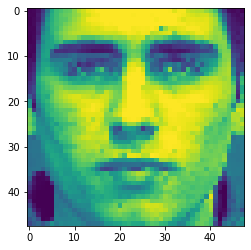

Original label: neutral
Predicted label: neutral
Image data:


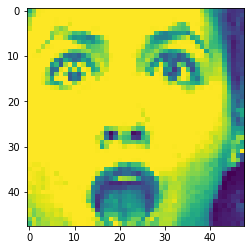

Original label: surprise
Predicted label: surprise
Image data:


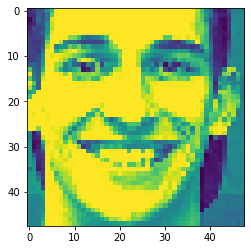

Original label: happy
Predicted label: happy
Image data:


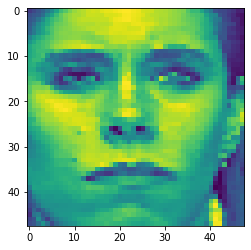

Original label: neutral
Predicted label: neutral


In [40]:
for i in range(len(validation_data[0])): 
    print("Image data:")
    plt.imshow(validation_data[0][i])
    plt.show()
    print("Original label:", EMOTION_MAPPING[np.argmax(validation_data[1][i])])
    print("Predicted label:", EMOTION_MAPPING[np.argmax(predictions[i])])